In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

### Functions

In [6]:
## Developed in NPX_find_bursts_testing.ipynb, this version is faster and only returns start times and spike counts ##
## For LTS bursts, often associated with thalamocortical units ##
def find_LTS_bursts(spike_times):
    ## Set ISI parameters ##
    pre_ISI = 0.1
    first_ISI = 0.005
    other_ISI = 0.01
    
    preISIs = np.diff(spike_times)[:-1]
    postISIs = np.diff(spike_times)[1:]
    ## Find starts ##
    bs_inds = np.nonzero((preISIs > pre_ISI) * (postISIs < first_ISI))[0]
    if len(bs_inds) == 0:
        return np.array([]), np.array([])
    
    burst_starts = bs_inds + 1 # +1 corrects for the actual spike ind
    ## Loop through burst starts to find spikes that belong to the burst
    burst_counts = []
    for st_ind in bs_inds:
        spkind = st_ind+1
        bcount = 1
        while (spkind < len(preISIs)) and (preISIs[spkind] < other_ISI):
            spkind += 1
            bcount += 1
        burst_counts.append(bcount)
    
    return spike_times[burst_starts], np.array(burst_counts)

# Load experiment

In [7]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


In [8]:
all_subexp[10:15]

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
10,wildtype,655956,estim_2022-12-15_10-07-59,saline,2165,"awake,saline",none,25,True,True,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shorted gnd",F:\psi_exp\mouse655956\estim_2022-12-15_10-07-...,"Good EEG, and RT units"
11,wildtype,689239,aw_iso_2023-08-09_11-15-42,isoflurane,0,"awake,isoflurane","13,28",25,True,True,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, mid CB","separate ref, shared gnd",F:\psi_exp\mouse689239\aw_iso_2023-08-09_11-15...,"Good EEG, and RT units, EP from high amp"
12,wildtype,703063,aw_psi_2023-11-15_11-08-12,psilocybin,3077,"awake,psilocybin","0,3,13",25,True,False,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, mid CB","separate ref, shared gnd",F:\psi_exp\mouse703063\aw_psi_2023-11-15_11-08...,"Many RT units, EP not good"
13,wildtype,703064,aw_iso_2023-11-29_11-23-30,isoflurane,0,"awake,isoflurane","3,9,15,16,21",25,True,False,NaN,"stainless steel skull screw, mid CB","stainless steel skull screw, left CB","separate ref, shared gnd",F:\psi_exp\mouse703064\aw_iso_2023-11-29_11-23...,"Many RT units, EP not good"
14,wildtype,709401,aw_iso_2023-12-13_09-55-07,isoflurane,0,"awake,isoflurane",3,25,True,True,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, mid CB","separate ref, shared gnd",F:\psi_exp\mouse709401\aw_iso_2023-12-13_09-55...,"Some RT, EP good at high amp"


# Test on one session

In [9]:
choose_sub = 1
exprow = all_subexp.iloc[choose_sub]
print(exprow.mouse)
exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)

644565
Experiment type: electrical stimulation


In [10]:
if exprow.NPX_analysis:
    print('Yes, this experiment has good NPX data.')
else:
    print('This experiment does NOT have good NPX data, skip it.')

Yes, this experiment has good NPX data.


In [11]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


Get coords for stim electrode

In [12]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [13]:
stim_elec_data

{'surface': {'area': 'MOs1', 'ccf_coords': [147, 55, 163]},
 'tip': {'area': 'MOs6b', 'ccf_coords': [157, 119, 164]}}

## Load other data

### Load stim log

In [14]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [15]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good
0,biphasic,50,0.0004,2961.90928,2961.90968,0,0.000000,True,False,True
1,biphasic,50,0.0004,2982.91487,2982.91527,0,0.000000,True,True,True
2,biphasic,50,0.0004,3001.93576,3001.93616,0,0.607456,False,False,True
3,biphasic,50,0.0004,3021.96011,3021.96051,0,0.303728,False,True,True
4,biphasic,50,0.0004,3042.75694,3042.75734,0,0.000000,True,False,True


### Load SWD events

In [16]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is.')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Session has no SWD file.')
    autoSWD_df = None

Whoope there it is.


### Load EEG to use the timestamps

In [17]:
eegts = np.load(exp.ephys_params['EEG']['timestamps'])

In [18]:
## Load the iso times ##
iso_level, isots = exp.load_analog_iso()

## Load unit data

In [19]:
evoked_folder = os.path.join(exp.data_folder, 'evoked_data')
fn_units_info = os.path.join(evoked_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

# unit_info.head()

Get the CV and burst count outside of SWDs

In [20]:
deltat = 1. # window size, s
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        print(' First stim: {:.2f} s; Iso on: {:.2f} s'.format(stim_log.onset.values[0], isots[iso_level > 4][0]))
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        print(' First stim: {:.2f} s; First injection: {:.2f}'.format(stim_log.onset.values[0], exprow.inj_time))
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)
if exprow.genotype == 'GAT1-KO':
    spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]

GAT1: choose time before any stimuli
 Spontaneous time: 2932.62 s


In [21]:
ISI_CV = []
prop2 = []
num_LTS_bursts = []
CV2 = []
ISI_CV_in = []
ISI_CV_out = []
num_bursts_in = []
num_bursts_out = []
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    uISI = np.diff(uspikes)
    ISI_CV.append(np.std(uISI) / np.mean(uISI))
    prop2.append(np.sum(uISI > 2) / len(uISI))
    ubursts, uburstcounts = find_LTS_bursts(uspikes)
    num_LTS_bursts.append(len(ubursts))
    cv_i = np.diff(uISI) / (uISI[:-1] + uISI[1:])
    CV2.append(2. * np.mean(np.abs(cv_i)))

    if exprow.genotype == 'GAT1-KO':
        in_ISI = []
        out_ISI = []
        in_burst = []
        out_burst = []
        for j in range(len(spontSWD)-1):
            SWDeventj = spontSWD.iloc[j]
            SWDeventjj = spontSWD.iloc[j+1]
        
            ## within SWD ##
            SWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0]]
            if len(SWDspikes) > 1:
                in_ISI.append(np.diff(SWDspikes))
            burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
            in_burst.append(ubursts[burstinds])
        
            ## out of SWD ##
            nonSWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0]]
            if len(nonSWDspikes) > 1:
                out_ISI.append(np.diff(nonSWDspikes))
            nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
            out_burst.append(ubursts[nonburstinds])
    
        if len(in_ISI) > 1:
            ISI_CV_in.append(np.std(np.concatenate(in_ISI)) / np.mean(np.concatenate(in_ISI)))
        else:
            ISI_CV_in.append(np.nan)
        if len(out_ISI) > 1:
            ISI_CV_out.append(np.std(np.concatenate(out_ISI)) / np.mean(np.concatenate(out_ISI)))
        else:
            ISI_CV_out.append(np.nan)
        num_bursts_in.append(len(np.concatenate(in_burst)))
        num_bursts_out.append(len(np.concatenate(out_burst)))


unit_info['CV_ISI'] = ISI_CV
unit_info['prop2'] = prop2
unit_info['num_LTS_bursts'] = num_LTS_bursts
unit_info['CV2'] = CV2
if exprow.genotype == 'GAT1-KO':
    unit_info['CV_ISI_in'] = ISI_CV_in
    unit_info['num_bursts_in'] = num_bursts_in
    unit_info['CV_ISI_out'] = ISI_CV_out
    unit_info['num_bursts_out'] = num_bursts_out
else:
    unit_info['CV_ISI_out'] = ISI_CV

## Classify cell types
<br> **STR classification** (a la Masmanidis lab, J Neurophysiol 2016): FS [spike_duration < 0.475], TAN [spike_duration > 0.55 & CV < 1.5], MSN [spike_duration > 0.55 & CV > 1.5]
<br> **STR classification** (a la bombcell, https://github.com/Julie-Fabre/bombcell/blob/main/py_bombcell/bombcell/classification.py): need spike duration, propLongISI, and postSpikeSuppression_ms properties to distinguish MSN, FS, TAN, and UIN (unidentified interneuron)
<br> **isocortex classification**: FS [spike_duration < 0.4], RS [spike_duration > 0.4]
<br> thalamus: need to figure out...

In [39]:
put_cell_type = []
for unitind, unitrow in unit_info.iterrows():
    if unitrow.parent_region == 'STR':
        if unitrow.spike_duration < 0.475:
            put_cell_type.append('FS')
        elif unitrow.spike_duration > 0.55:
            if unitrow.CV_ISI_out < 1.0: # Masmanidis lab uses 1.5, Berke lab opto tagging of TANs finds most CV<1.0; also tried CV only out of SWD; also tried CV2<1.0
                put_cell_type.append('TAN')
            else:
                put_cell_type.append('MSN')
        else:
            put_cell_type.append('unc')
    elif unitrow.parent_region in ['MO', 'SS', 'VIS', 'PL', 'ACA', 'ILA', 'ORB', 'RSP', 'HIP']:
        if unitrow.spike_duration < 0.4:
            put_cell_type.append('FS')
        else:
            put_cell_type.append('RS')
    elif unitrow.parent_region == 'TH':
        if unitrow.spike_duration < 0.325:
            put_cell_type.append('pRT')
        else:
            put_cell_type.append('TC')
    else:
        put_cell_type.append('unc')
unit_info['cell_type'] = put_cell_type

In [40]:
unit_info.head(10)

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,cell_type
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH,2.425659,0.014264,590,1.034553,1.398043,138,2.087172,264,TC
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH,2.072512,0.000883,3054,0.898940,1.576292,843,1.884850,1063,TC
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH,2.638771,0.072991,339,1.163091,1.528207,76,1.859698,141,TC
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH,2.675274,0.018834,1559,0.980496,2.292351,471,2.225969,653,TC
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH,1.560503,0.002114,2884,1.045671,1.376947,971,1.531211,1103,TC
5,B5,probeB,1,3680,0.343384,PO,269,162,173,4.348966,0.99,0.195873,0.079074,18920,TH,2.304097,0.018341,1169,0.997812,1.728330,390,1.990033,474,TC
6,B6,probeB,5,3640,0.357119,PO,269,160,173,4.956259,0.99,0.056117,0.001053,21562,TH,2.609929,0.015352,1765,0.924425,2.095463,597,2.079122,685,TC
7,B7,probeB,1,3680,0.412060,PO,269,162,173,1.392956,0.99,1.287662,0.451247,6060,TH,2.983437,0.068823,243,1.129227,1.312132,11,1.822043,54,TC
8,B8,probeB,2,3660,0.384590,PO,269,161,173,7.798258,0.99,0.461851,0.001503,33926,TH,2.581827,0.005306,2625,0.959916,1.815505,833,2.150234,980,TC
9,B9,probeB,2,3660,0.467002,PO,269,161,173,2.650295,0.99,0.171719,0.481475,11530,TH,2.257924,0.044843,348,1.072486,1.556459,124,1.849811,161,TC


## Choose a parent region to begin classification

### STR

In [24]:
pregion = 'STR'
FR_min = 0.05
regi_unitdf = unit_info[(unit_info['parent_region'] == pregion) & (unit_info['firing_rate'] > FR_min)]
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head(10)

534
['CP' 'LSv' 'VL' 'ccg']
['probeF']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,cell_type
724,F20,probeF,14,3520,0.563149,LSv,198,193,195,0.914157,0.99,0.721665,0.093206,3977,STR,1.123152,0.160966,30,1.028115,0.987107,5,1.160075,19,MSN
725,F22,probeF,17,3500,0.563149,LSv,198,192,195,8.537493,0.99,0.023640,0.108883,37142,STR,1.191723,0.000081,57,0.884505,1.032124,18,1.083783,28,MSN
726,F23,probeF,17,3500,0.494472,LSv,198,192,195,8.169486,0.99,0.121344,0.295591,35541,STR,1.257512,0.000535,200,0.976528,1.124745,51,1.195859,79,unc
727,F24,probeF,18,3480,0.563149,LSv,198,192,195,2.815796,0.99,0.021732,0.025311,12250,STR,0.938953,0.003184,9,0.915911,0.894587,1,0.903967,2,TAN
728,F26,probeF,19,3480,0.590620,LSv,198,191,195,0.661770,0.99,0.000000,0.023384,2879,STR,1.735865,0.212300,0,1.112921,1.166704,0,2.126773,0,MSN
729,F27,probeF,20,3460,0.412060,LSv,198,191,194,1.600062,0.99,0.100955,0.081672,6961,STR,1.557400,0.073563,12,1.068644,1.169478,2,1.672944,6,FS
730,F29,probeF,22,3440,0.727973,LSv,197,190,194,0.576031,0.99,0.778948,0.292430,2506,STR,1.285663,0.279042,22,1.044105,0.974562,4,1.411877,12,MSN
731,F30,probeF,23,3440,0.563149,LSv,197,190,194,1.786019,0.99,0.054018,0.008523,7770,STR,1.194874,0.037843,25,1.065653,0.980689,5,1.217836,10,MSN
732,F31,probeF,23,3440,0.645561,LSv,197,190,194,2.172415,0.99,0.018255,0.016012,9451,STR,1.118162,0.021376,6,0.910483,0.872638,3,1.011698,2,MSN
733,F32,probeF,23,3440,0.453266,LSv,197,190,194,10.056874,0.99,0.001704,0.000120,43752,STR,1.215235,0.000069,23,0.852740,1.076444,7,1.088892,11,FS


STR classification (a la Masmanidis lab, J Neurophysiol 2016)

Text(0.5, 1.0, 'STR putative cell types')

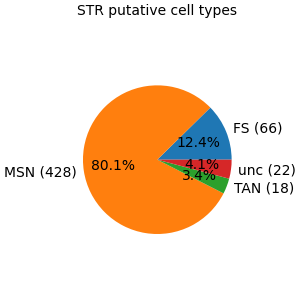

In [25]:
labels = []
count = []
for typei in np.unique(regi_unitdf['cell_type'].values):
    tdf = regi_unitdf[regi_unitdf['cell_type'] == typei]
    labels.append('{} ({:d})'.format(typei, len(tdf)))
    count.append(len(tdf))

fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
ax.pie(count, labels=labels, autopct='%1.1f%%')
ax.axis('equal')
ax.set_title('{} putative cell types'.format(pregion))

Text(0.5, 0.98, 'STR metrics, 534 units')

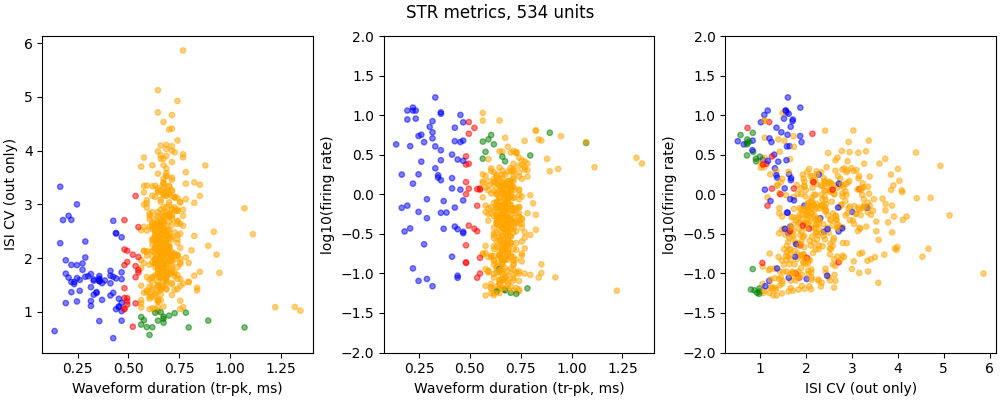

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True)

putcols = {'MSN': 'orange', 'FS': 'b', 'unc': 'r', 'TAN': 'g'}
colors = np.array([putcols[x] for x in regi_unitdf['cell_type'].values])
axs[0].scatter(regi_unitdf['spike_duration'].values, regi_unitdf['CV_ISI_out'].values, c=colors, s=15, alpha=0.5)
axs[0].set_xlabel('Waveform duration (tr-pk, ms)')
axs[0].set_ylabel('ISI CV (out only)')


axs[1].scatter(regi_unitdf['spike_duration'].values, np.log10(regi_unitdf['firing_rate'].values), c=colors, s=15, alpha=0.5)
axs[1].set_xlabel('Waveform duration (tr-pk, ms)')
axs[1].set_ylabel('log10(firing rate)')
axs[1].set_ylim([-2, 2])

axs[2].scatter(regi_unitdf['CV_ISI_out'].values, np.log10(regi_unitdf['firing_rate'].values), c=colors, s=15, alpha=0.5)
axs[2].set_xlabel('ISI CV (out only)')
axs[2].set_ylabel('log10(firing rate)')
axs[2].set_ylim([-2, 2])

fig.suptitle('{} metrics, {:d} units'.format(pregion, len(regi_unitdf)))

### Cortex

In [41]:
pregion = 'HIP'
FR_min = 0.05
regi_unitdf = unit_info[(unit_info['parent_region'] == pregion) & (unit_info['firing_rate'] > FR_min)]
print(len(regi_unitdf))
# print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head(10)

311
['probeB' 'probeC']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,cell_type
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH,2.425659,0.014264,590,1.034553,1.398043,138,2.087172,264,TC
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH,2.072512,0.000883,3054,0.898940,1.576292,843,1.884850,1063,TC
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH,2.638771,0.072991,339,1.163091,1.528207,76,1.859698,141,TC
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH,2.675274,0.018834,1559,0.980496,2.292351,471,2.225969,653,TC
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH,1.560503,0.002114,2884,1.045671,1.376947,971,1.531211,1103,TC
5,B5,probeB,1,3680,0.343384,PO,269,162,173,4.348966,0.99,0.195873,0.079074,18920,TH,2.304097,0.018341,1169,0.997812,1.728330,390,1.990033,474,TC
6,B6,probeB,5,3640,0.357119,PO,269,160,173,4.956259,0.99,0.056117,0.001053,21562,TH,2.609929,0.015352,1765,0.924425,2.095463,597,2.079122,685,TC
7,B7,probeB,1,3680,0.412060,PO,269,162,173,1.392956,0.99,1.287662,0.451247,6060,TH,2.983437,0.068823,243,1.129227,1.312132,11,1.822043,54,TC
8,B8,probeB,2,3660,0.384590,PO,269,161,173,7.798258,0.99,0.461851,0.001503,33926,TH,2.581827,0.005306,2625,0.959916,1.815505,833,2.150234,980,TC
9,B9,probeB,2,3660,0.467002,PO,269,161,173,2.650295,0.99,0.171719,0.481475,11530,TH,2.257924,0.044843,348,1.072486,1.556459,124,1.849811,161,TC


Text(0.5, 1.0, 'TH putative cell types')

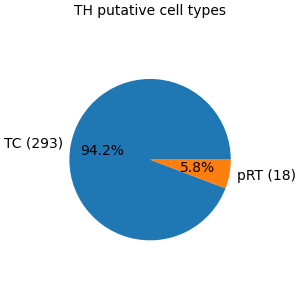

In [42]:
labels = []
count = []
for typei in np.unique(regi_unitdf['cell_type'].values):
    tdf = regi_unitdf[regi_unitdf['cell_type'] == typei]
    labels.append('{} ({:d})'.format(typei, len(tdf)))
    count.append(len(tdf))

fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
ax.pie(count, labels=labels, autopct='%1.1f%%')
ax.axis('equal')
ax.set_title('{} putative cell types'.format(pregion))

Choose an example unit

In [67]:
unitind = 1450
unitrow = unit_info.iloc[unitind]
print('Unit {}, {}: spike duration={:.2f}, spike count={:d}'.format(unitrow.unit_id, unitrow.region, unitrow.spike_duration, unitrow.spike_count))

Unit F165, CP: spike duration=0.25, spike count=8338


In [68]:
uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
print(len(uspikes))

8338


In [69]:
uISI = np.diff(uspikes)
uCV = np.std(uISI) / np.mean(uISI)
print(uCV)

1.200868909425438


In [70]:
ubursts, uburstcounts = find_LTS_bursts(uspikes)
print(len(ubursts))

310


Calculate the proportion of ISIs greater than 2 s (from https://www.pnas.org/doi/10.1073/pnas.2410828121)

In [71]:
prop2 = np.sum(uISI > 2) / len(uISI)
print(prop2)

0.09247930910399424


Calculate mean CV2 (https://elephant.readthedocs.io/en/latest/reference/_toctree/statistics/elephant.statistics.cv2.html#elephant.statistics.cv2)

In [72]:
cv_i = np.diff(uISI) / (uISI[:-1] + uISI[1:])
CV2 = 2. * np.mean(np.abs(cv_i))
print(CV2)

1.0932504410368913


In [73]:
np.min(regi_unitdf['firing_rate'].values)

0.0071182225037111

In [35]:
pregion = 'TH'
FR_min = 0.05
regi_unitdf = unit_info[(unit_info['parent_region'] == pregion) & (unit_info['firing_rate'] > FR_min)]
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head(10)

311
['LD' 'PO' 'VL' 'fi' 'root']
['probeB' 'probeC']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,cell_type
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH,2.425659,0.014264,590,1.034553,1.398043,138,2.087172,264,unc
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH,2.072512,0.000883,3054,0.898940,1.576292,843,1.884850,1063,unc
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH,2.638771,0.072991,339,1.163091,1.528207,76,1.859698,141,unc
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH,2.675274,0.018834,1559,0.980496,2.292351,471,2.225969,653,unc
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH,1.560503,0.002114,2884,1.045671,1.376947,971,1.531211,1103,unc
5,B5,probeB,1,3680,0.343384,PO,269,162,173,4.348966,0.99,0.195873,0.079074,18920,TH,2.304097,0.018341,1169,0.997812,1.728330,390,1.990033,474,unc
6,B6,probeB,5,3640,0.357119,PO,269,160,173,4.956259,0.99,0.056117,0.001053,21562,TH,2.609929,0.015352,1765,0.924425,2.095463,597,2.079122,685,unc
7,B7,probeB,1,3680,0.412060,PO,269,162,173,1.392956,0.99,1.287662,0.451247,6060,TH,2.983437,0.068823,243,1.129227,1.312132,11,1.822043,54,unc
8,B8,probeB,2,3660,0.384590,PO,269,161,173,7.798258,0.99,0.461851,0.001503,33926,TH,2.581827,0.005306,2625,0.959916,1.815505,833,2.150234,980,unc
9,B9,probeB,2,3660,0.467002,PO,269,161,173,2.650295,0.99,0.171719,0.481475,11530,TH,2.257924,0.044843,348,1.072486,1.556459,124,1.849811,161,unc


Text(0, 0.5, 'ISI CV (out only)')

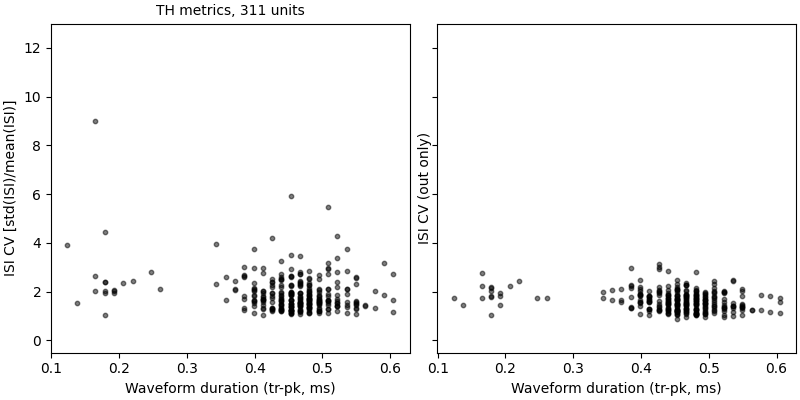

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True, sharey=True)

axs[0].scatter(regi_unitdf['spike_duration'].values, regi_unitdf['CV_ISI'].values, color='k', s=10, alpha=0.5)
axs[0].set_xlabel('Waveform duration (tr-pk, ms)')
axs[0].set_ylabel('ISI CV [std(ISI)/mean(ISI)]')
axs[0].set_title('{} metrics, {:d} units'.format(pregion, len(regi_unitdf)))
axs[0].set_ylim([-0.5, 13])

axs[1].scatter(regi_unitdf['spike_duration'].values, regi_unitdf['CV_ISI_out'].values, color='k', s=10, alpha=0.5)
axs[1].set_xlabel('Waveform duration (tr-pk, ms)')
axs[1].set_ylabel('ISI CV (out only)')
# axs[0].set_title('{} metrics, {:d} units'.format(pregion, len(regi_unitdf)))

Text(0, 0.5, 'CV2')

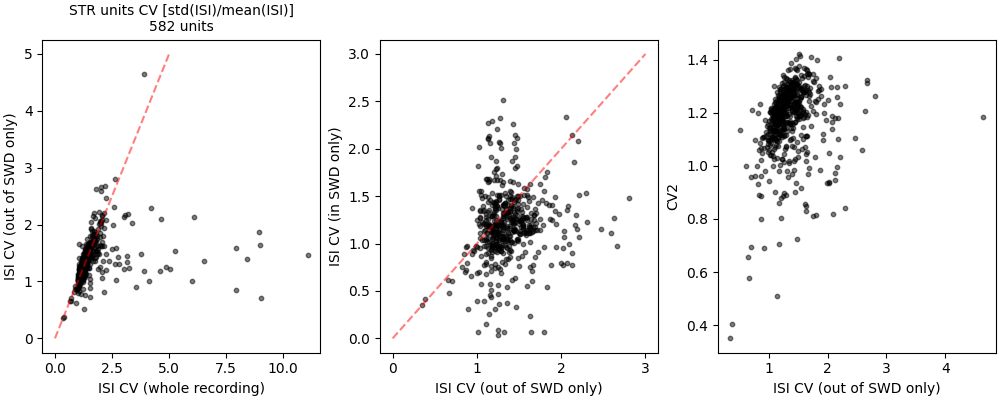

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True)
axs[0].plot([0,5], [0,5], c='r', linestyle='dashed', alpha=0.5)
axs[0].scatter(regi_unitdf['CV_ISI'].values, regi_unitdf['CV_ISI_out'].values, color='k', s=10, alpha=0.5)
axs[0].set_xlabel('ISI CV (whole recording)')
axs[0].set_ylabel('ISI CV (out of SWD only)')
axs[0].set_title('{} units CV [std(ISI)/mean(ISI)]\n{:d} units'.format(pregion, len(regi_unitdf)))
# ax.set_ylim([-0.5, 13])

axs[1].plot([0,3], [0,3], c='r', linestyle='dashed', alpha=0.5)
axs[1].scatter(regi_unitdf['CV_ISI_out'].values, regi_unitdf['CV_ISI_in'].values, color='k', s=10, alpha=0.5)
axs[1].set_xlabel('ISI CV (out of SWD only)')
axs[1].set_ylabel('ISI CV (in SWD only)')

# axs[2].plot([0,3], [0,3], c='r', linestyle='dashed', alpha=0.5)
axs[2].scatter(regi_unitdf['CV_ISI_out'].values, regi_unitdf['CV2'].values, color='k', s=10, alpha=0.5)
axs[2].set_xlabel('ISI CV (out of SWD only)')
axs[2].set_ylabel('CV2')

Text(0.5, 1.0, 'TH\nNumber of LTS bursts')

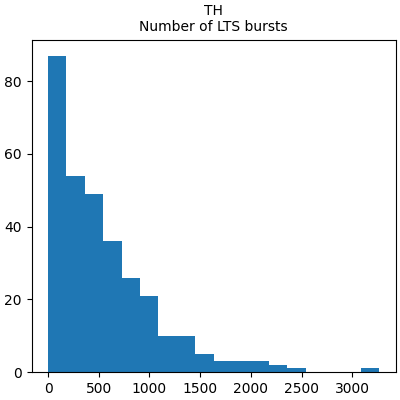

In [37]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(regi_unitdf['num_bursts_out'].values)
ax.set_title('{}\nNumber of LTS bursts'.format(pregion))

Text(0.5, 1.0, 'TH\nProportion of time in ISI>2s')

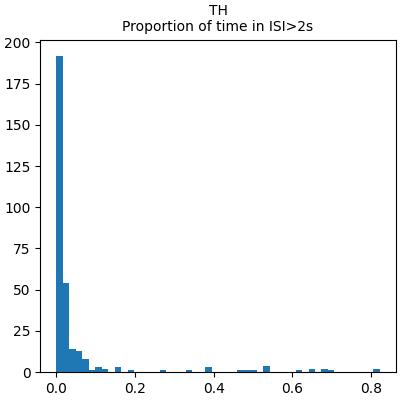

In [38]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(regi_unitdf['prop2'].values, bins=50)
ax.set_title('{}\nProportion of time in ISI>2s'.format(pregion))

## Loop through all units to get spontaneous firing rates

In [21]:
deltat = 1. # window size, s
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        print(' First stim: {:.2f} s; Iso on: {:.2f} s'.format(stim_log.onset.values[0], isots[iso_level > 4][0]))
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        print(' First stim: {:.2f} s; First injection: {:.2f}'.format(stim_log.onset.values[0], exprow.inj_time))
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)
spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]

GAT1: choose time before any stimuli
 Spontaneous time: 1723.91 s


In [22]:
compstart = time.time()
spontFR = []
spontBR = []
spont_burstratio = []
units_SWD_FR = []
units_nonSWD_FR = []
units_SWD_BR = []
units_nonSWD_BR = []
units_SWD_burstratio = []
units_nonSWD_burstratio = []
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
    ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']
    ## Spontaneous ##
    spikecounts, edges = np.histogram(uspikes, spontbins)
    spontFR.append(np.mean(spikecounts / deltat))
    burstcounts, edges = np.histogram(ubursts, spontbins)
    spontBR.append(np.mean(burstcounts / deltat))
    ## Burst ratio ##
    spont_burstratio.append(
        np.sum(ubcs[np.nonzero((ubursts >= atime) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= atime) & (uspikes <= btime))[0]))


    ## Get SWD info ##
    event_SWD_FR = []
    event_SWD_BR = []
    totSWDspikec = []
    totSWDburstc = []
    event_nonSWD_FR = []
    event_nonSWD_BR = []
    totnonSWDspikec = []
    totnonSWDburstc = []
    for j in range(len(spontSWD)-1):
        SWDeventj = spontSWD.iloc[j]
        SWDeventjj = spontSWD.iloc[j+1]
    
        ## within SWD ##
        SWDspikec = len(np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0])
        event_SWD_FR.append(SWDspikec / (SWDeventj.offset - SWDeventj.onset))
        totSWDspikec.append(SWDspikec)
    
        burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
        event_SWD_BR.append(len(burstinds) / (SWDeventj.offset - SWDeventj.onset))
        totSWDburstc.append(np.sum(ubcs[burstinds]))
    
        ## out of SWD ##
        nonSWDspikec = len(np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0])
        event_nonSWD_FR.append(nonSWDspikec / (SWDeventjj.onset - SWDeventj.offset))
        totnonSWDspikec.append(nonSWDspikec)
    
        nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
        event_nonSWD_BR.append(len(nonburstinds) / (SWDeventjj.onset - SWDeventj.offset))
        totnonSWDburstc.append(np.sum(ubcs[nonburstinds]))
    units_SWD_FR.append(np.mean(event_SWD_FR))
    units_nonSWD_FR.append(np.mean(event_nonSWD_FR))
    units_SWD_BR.append(np.mean(event_SWD_BR))
    units_nonSWD_BR.append(np.mean(event_nonSWD_BR))
    units_SWD_burstratio.append(np.sum(totSWDburstc) / np.sum(totSWDspikec))
    units_nonSWD_burstratio.append(np.sum(totnonSWDburstc) / np.sum(totnonSWDspikec))

unit_info['spont_FR'] = spontFR
unit_info['spont_BR'] = spontBR
unit_info['burst_ratio'] = spont_burstratio
unit_info['SWD_FR'] = units_SWD_FR
unit_info['nonSWD_FR'] = units_nonSWD_FR
unit_info['SWD_BR'] = units_SWD_BR
unit_info['nonSWD_BR'] = units_nonSWD_BR
unit_info['SWD_burst_ratio'] = units_SWD_burstratio
unit_info['nonSWD_burst_ratio'] = units_nonSWD_burstratio
compend = time.time()
print('Computation time: {:.2f} min'.format((compend-compstart)/60))

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Computation time: 3.64 min


In [23]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR,nonSWD_FR,SWD_BR,nonSWD_BR,SWD_burst_ratio,nonSWD_burst_ratio
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,9.418763,0.99,0.016637,0.000034,62190,TH,9.100987,0.315148,0.063273,5.194705,8.827456,0.297656,0.292783,0.116959,0.060632
1,B1,probeB,0,3640,0.590620,AMv,253,179,195,8.409945,0.99,0.089089,0.307189,55529,TH,7.189205,0.066164,0.016055,3.045485,6.823664,0.095416,0.066364,0.048662,0.014783
2,B2,probeB,0,3640,0.535678,AMv,253,179,195,4.729525,0.99,0.139577,0.356767,31228,TH,4.597795,0.030760,0.011478,1.649302,4.373807,0.031793,0.027418,0.022727,0.011172
3,B3,probeB,0,3640,0.576884,AMv,253,179,195,2.060496,0.99,0.361000,0.500000,13605,TH,2.113175,0.033662,0.027991,1.149698,1.945563,0.035524,0.036650,0.054422,0.026911
4,B4,probeB,1,3640,0.508208,AMv,253,179,195,6.020648,0.99,0.075170,0.041239,39753,TH,4.760302,0.184562,0.080795,3.632534,4.482238,0.140764,0.142553,0.080913,0.080850


Plot all units from regions

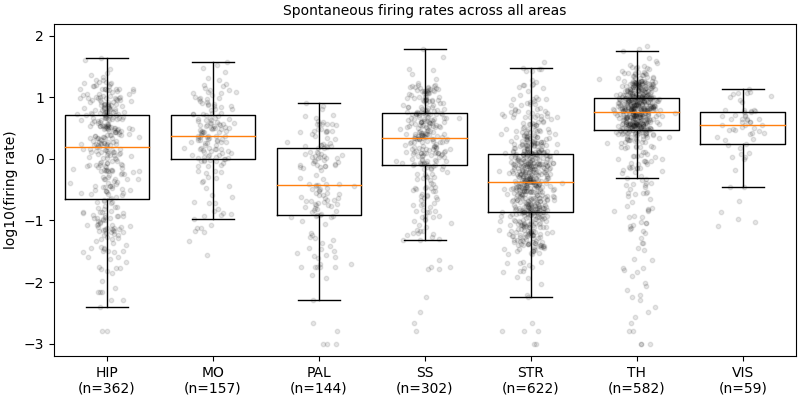

In [24]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yvals = np.log10(regidf['spont_FR'].values + 1E-3)
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False,)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.arange(len(parent_regions)))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.2, 2.2])
ax.set_ylabel('log10(firing rate)')
ax.set_title('Spontaneous firing rates across all areas')

## Save ##
fig_name = '{}{}_spontFR_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

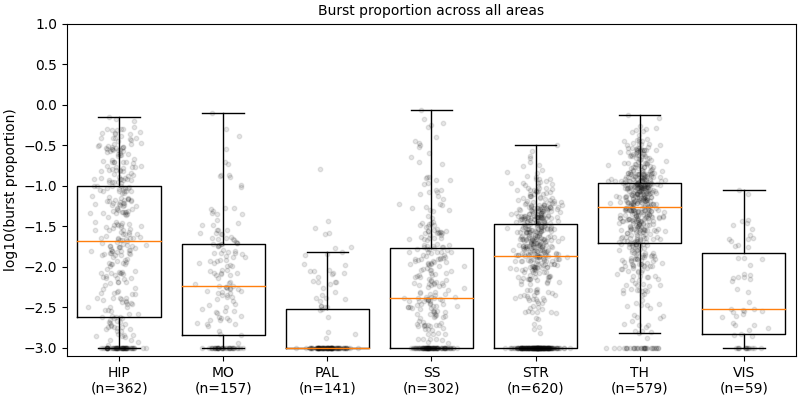

In [29]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    yvals = np.log10(regidf['burst_ratio'].values[~np.isnan(regidf['burst_ratio'].values)] + 1E-3)
    rlabels.append('{}\n(n={:d})'.format(pregi, len(yvals)))
    # yvals = regidf['burst_ratio'].values
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False,)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.arange(len(parent_regions)))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.1, 1.0])
ax.set_ylabel('log10(burst proportion)')
ax.set_title('Burst proportion across all areas')

## Save ##
fig_name = '{}{}_spontBurstproportion_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

## Investigate some single units

In [25]:
regi_unitdf = unit_info[unit_info['parent_region'] == 'STR']
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
regi_unitdf.head()

586
['CP' 'ccb']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR
1643,F32,probeF,42,3260,0.659296,CP,205,182,186,0.008169,0.41,0.000000,0.500000,58,STR,0.006893,0.000000,0.000000,0.008739
1644,F33,probeF,43,3260,0.343384,CP,205,182,186,10.099695,0.99,0.007245,0.000308,71709,STR,10.185578,0.001591,0.000677,5.560259
1645,F34,probeF,43,3260,0.618090,CP,205,182,186,0.759143,0.99,0.366406,0.033224,5390,STR,0.347826,0.000000,0.000000,0.266990
1646,F36,probeF,50,3180,0.782915,CP,204,179,184,0.004789,0.25,0.000000,0.500000,34,STR,0.002651,0.000000,0.000000,0.001390
1647,F37,probeF,53,3160,0.247236,CP,204,178,184,8.264091,0.99,0.006184,0.046901,58676,STR,10.238600,0.006893,0.002019,6.677388


In [26]:
regi_unitdf[80:90]

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR
1723,F128,probeF,96,2720,0.645561,CP,200,161,177,1.115052,0.99,10.826759,0.025554,7917,STR,1.172322,0.010604,0.028042,1.914032
1724,F129,probeF,96,2720,0.645561,CP,200,161,177,0.271827,0.99,24.290916,0.074886,1930,STR,0.278367,0.001060,0.011429,0.595310
1725,F130,probeF,96,2720,0.618090,CP,200,161,177,0.630412,0.99,10.626480,0.120878,4476,STR,0.583775,0.007423,0.040872,0.933454
1726,F131,probeF,97,2720,0.645561,CP,200,160,176,1.311246,0.99,6.601136,0.022852,9310,STR,1.969247,0.015376,0.025848,2.662587
1727,F132,probeF,97,2720,0.673032,CP,200,160,176,0.268165,0.99,9.543091,0.025758,1904,STR,0.263521,0.000530,0.006036,0.582097
1728,F133,probeF,97,2720,0.631826,CP,200,160,176,0.723932,0.99,8.159027,0.004859,5140,STR,0.922057,0.007423,0.025877,1.693579
1729,F134,probeF,97,2720,0.810385,CP,200,160,176,0.210982,0.99,27.276196,0.032920,1498,STR,0.264581,0.002121,0.024048,0.562441
1730,F136,probeF,98,2700,0.631826,CP,200,160,176,0.178589,0.96,26.482628,0.033632,1268,STR,0.167020,0.001060,0.022222,0.284228
1731,F137,probeF,98,2700,0.755444,CP,200,160,176,0.148730,0.99,11.932234,0.047205,1056,STR,0.110817,0.000530,0.014354,0.277487
1732,F138,probeF,98,2700,0.604355,CP,200,160,176,1.308289,0.99,8.975004,0.341608,9289,STR,0.986744,0.015907,0.051585,1.724124


In [27]:
unitind = 792
unitrow = unit_info.iloc[unitind]
print('Unit {}, {}: spike duration={:.2f}, spike count={:d}'.format(unitrow.unit_id, unitrow.region, unitrow.spike_duration, unitrow.spike_count))

Unit C511, dhc: spike duration=0.49, spike count=37971


In [28]:
uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
print(len(uspikes))
ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
print(len(ubursts))
ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']

37971
121


### Get the spontaneous time window to get mean firing rate

In [29]:
deltat = 1.0 # size of time bins (s)

In [30]:
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)

GAT1: choose time before any stimuli
 Spontaneous time: 1886.30 s


In [31]:
## Firing rate ##
spikecounts, edges = np.histogram(uspikes, spontbins)
unitFR = np.mean(spikecounts / deltat)
print('Unit {} mean firing rate: {:.2f} Hz [log10={:.2f}]'.format(unitrow.unit_id, unitFR, np.log10(unitFR)))

## Burst rate ##
burstcounts, edges = np.histogram(ubursts, spontbins)
unitBR = np.mean(burstcounts / deltat)
print('Unit {} mean burst rate: {:.2f} Hz [log10={:.2f}]'.format(unitrow.unit_id, unitBR, np.log10(unitBR)))

## Compute the burst proportion: # spikes in bursts / # total spikes ##
burst_ratio = np.sum(ubcs[np.nonzero((ubursts >= atime) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= atime) & (uspikes <= btime))[0])
print('Unit {} burst proportion: {:.2f}'.format(unitrow.unit_id, burst_ratio))

Unit C511 mean firing rate: 4.95 Hz [log10=0.69]
Unit C511 mean burst rate: 0.01 Hz [log10=-2.10]
Unit C511 burst proportion: 0.00


### Get spontaneous firing for SWD and not

In [32]:
autoSWD_df.tail()

,onset,offset,duration,spike_count,SWD_spike_times
1047,7092.399350,7093.288549,0.889199,4,"[7092.399349751857, 7092.722949542853, 7093.09..."
1048,7125.280934,7125.966134,0.685200,4,"[7125.280934257315, 7125.436934206937, 7125.79..."
1049,7131.890532,7132.539332,0.648800,3,"[7131.890532122845, 7132.208932020022, 7132.53..."
1050,7144.637728,7145.770128,1.132400,5,"[7144.63772800633, 7144.952127904799, 7145.269..."
1051,7149.089327,7149.818126,0.728800,4,"[7149.089326568754, 7149.474526444359, 7149.64..."


In [33]:
spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]
spontSWD.tail()

,onset,offset,duration,spike_count,SWD_spike_times
385,1906.785480,1907.295476,0.509997,3,"[1906.7854796428342, 1907.1174774985468, 1907...."
386,1911.672248,1913.563836,1.891588,11,"[1911.6722480804754, 1911.8194471297552, 1911...."
387,1915.677422,1916.507817,0.830395,6,"[1915.6774222121037, 1915.8370211812958, 1916...."
388,1917.570610,1918.447804,0.877194,6,"[1917.5706099844992, 1917.741408881354, 1917.9..."
389,1932.274915,1932.839711,0.564796,4,"[1932.2749150132404, 1932.457313835174, 1932.6..."


In [34]:
compstart = time.time()
all_SWD_FR = []
all_SWD_BR = []
totSWDspikec = []
totSWDburstc = []
all_nonSWD_FR = []
all_nonSWD_BR = []
totnonSWDspikec = []
totnonSWDburstc = []
for j in range(len(spontSWD)-1):
    SWDeventj = spontSWD.iloc[j]
    SWDeventjj = spontSWD.iloc[j+1]

    ## within SWD ##
    SWDspikec = len(np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0])
    all_SWD_FR.append(SWDspikec / (SWDeventj.offset - SWDeventj.onset))
    totSWDspikec.append(SWDspikec)

    burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
    all_SWD_BR.append(len(burstinds) / (SWDeventj.offset - SWDeventj.onset))
    totSWDburstc.append(np.sum(ubcs[burstinds]))

    ## out of SWD ##
    nonSWDspikec = len(np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0])
    all_nonSWD_FR.append(nonSWDspikec / (SWDeventjj.onset - SWDeventj.offset))
    totnonSWDspikec.append(nonSWDspikec)

    nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
    all_nonSWD_BR.append(len(nonburstinds) / (SWDeventjj.onset - SWDeventj.offset))
    totnonSWDburstc.append(np.sum(ubcs[nonburstinds]))
compend = time.time()
print(compend - compstart)

0.2887582778930664


In [46]:
print(np.mean(all_SWD_FR))
print(np.mean(all_nonSWD_FR))

4.3350227633322875
5.189754382288044


In [47]:
print(np.mean(all_SWD_BR))
print(np.mean(all_nonSWD_BR))

0.0017206665486152013
0.007092745842638542


In [57]:
print(np.sum(totSWDburstc) / np.sum(totSWDspikec))
print(np.sum(totnonSWDburstc) / np.sum(totnonSWDspikec))

0.0017201834862385322
0.005693855932203389


In [55]:
np.sum(totSWDburstc)

3

Individual trial

In [34]:
indi = 0
SWDeventi = spontSWD.iloc[indi]
SWDeventii = spontSWD.iloc[indi+1]

In [35]:
SWDeventi

onset                                                      55.904357
offset                                                     56.411553
duration                                                    0.507196
spike_count                                                        4
SWD_spike_times    [55.904356981838816, 56.06715561497322, 56.237...
Name: 0, dtype: object

In [36]:
SWDeventii

onset                                                      61.299912
offset                                                     63.137896
duration                                                    1.837985
spike_count                                                        9
SWD_spike_times    [61.299911680487725, 61.5323097292619, 61.8255...
Name: 1, dtype: object

In [41]:
SWDspikec = len(np.nonzero((uspikes >= SWDeventi.onset) & (uspikes <= SWDeventi.offset))[0])
SWD_FR = SWDspikec / (SWDeventi.offset - SWDeventi.onset)
print(SWD_FR)

nonSWDspikec = len(np.nonzero((uspikes >= SWDeventi.offset) & (uspikes <= SWDeventii.onset))[0])
nonSWD_FR = nonSWDspikec / (SWDeventii.onset - SWDeventi.offset)
print(nonSWD_FR)

0.0
5.523325974423183


In [42]:
SWDburstc = len(np.nonzero((ubursts >= SWDeventi.onset) & (ubursts <= SWDeventi.offset))[0])
SWD_BR = SWDburstc / (SWDeventi.offset - SWDeventi.onset)
print(SWD_BR)

nonSWDburstc = len(np.nonzero((ubursts >= SWDeventi.offset) & (ubursts <= SWDeventii.onset))[0])
nonSWD_BR = nonSWDburstc / (SWDeventii.onset - SWDeventi.offset)
print(nonSWD_BR)

0.0
0.0
